In [1]:
import pandas as pd

df = pd.read_csv("df_clean.csv")

df.head()

,album_type,track_duration,nombre_artist,track_release_month,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pays_du_producteur,popularity
0,album,30000,1,December,0.3210,0.952,6.0,-16.922,1.0,0.2100,0.7050,0.978,0.3400,0.03230,101.659,4.0,AU,0.0
1,album,30000,1,January,0.2750,0.912,3.0,-23.424,1.0,0.0704,0.9670,0.916,0.1990,0.00000,37.771,4.0,US,35.0
2,album,30000,1,March,0.1760,0.999,2.0,-25.388,1.0,0.0786,0.0677,0.662,0.7620,0.00001,98.109,4.0,ZZ,59.0
3,album,30000,1,December,0.0837,0.208,7.0,-20.947,1.0,0.0422,0.7000,0.880,0.0606,0.06500,168.334,5.0,GB,35.0
4,album,30000,1,December,0.2140,0.236,7.0,-20.772,1.0,0.0448,0.6780,0.878,0.0637,0.03920,79.725,4.0,GB,38.0


In [3]:
df['key']=df[('key')].astype(object)

In [8]:
from sklearn.model_selection import train_test_split

X=df.drop(['popularity'],axis=1)
y=df['popularity']
X_train,X_test,y_train,y_test = train_test_split(X, y,shuffle=True, test_size=0.2,random_state=42,stratify=X['pays_du_producteur'])




In [9]:
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)
categorial_features=list(X.select_dtypes( exclude=['int', 'float']).columns)



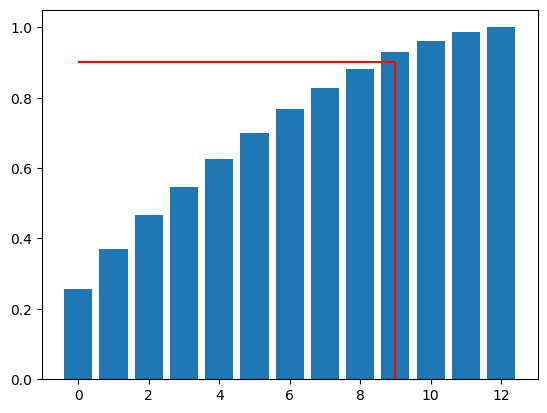

In [10]:
from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,PolynomialFeatures
from sklearn.decomposition import PCA

numeric_transformer = Pipeline([
        # ('log', FunctionTransformer(func=np.log1p)),
        ('standard', StandardScaler()),  # Centrer réduire
        # ('pca', PCA(n_components=8)),
        # ('polyanomie',PolynomialFeatures()) # après standardisation
        ])



from sklearn.preprocessing import OneHotEncoder
# categorical_transformer = OneHotEncoder(sparse=True)

categorical_transformer = Pipeline([
         ('onehot',OneHotEncoder(drop='if_binary')), 
        #  ('polyanomie',PolynomialFeatures()) # après standardisation
        ])

# ############### IV.d Combinaison ##############
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ],
    # remainder="passthrough" 
)

In [20]:
import xgboost as xgb
regressor=xgb.XGBRegressor(decisiontree__n_estimators= 700, decisiontree__max_depth= 5, decisiontree__learning_rate = 0.015, eval_metric='rmsle',random_state=42)

pipe_xgb_regressor = Pipeline([
     ('preprocessor', preprocessor),
     ('decisiontree', regressor)
])

In [21]:
import mlflow


mlflow.set_experiment("XGBregressor_models")
mlflow.sklearn.autolog()
# premier run
with mlflow.start_run(run_name='reg_log_regressor'):
  
  pipe_xgb_regressor.fit(X_train, y_train)

2023/03/02 15:05:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/03/02 15:05:28 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standard',
                                                  StandardScaler())]),
                                 ['track_duration', 'nombre_artist',
                                  'danceability', 'energy', 'loudness', 'mode',
                                  'speechiness', 'acousticness',
                                  'instrumentalness', 'liveness', 'valence',
               ...`
2023/03/02 15:05:28 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `ColumnTransformer(transformers=[('num',
             

[15:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "decisiontree__learning_rate", "decisiontree__max_depth", "decisiontree__n_estimators" } are not used.



2023/03/02 15:05:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/leonzhang/Desktop/Projet-r-capitulatif---Machine-Learning/env/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
